# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. 

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from sducs2019.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from sducs2019.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'sducs2019/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from sducs2019.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from sducs2019.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#pass
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, rs)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 84.912564
iteration 100 / 1500: loss 83.421196
iteration 200 / 1500: loss 81.934419
iteration 300 / 1500: loss 80.507176
iteration 400 / 1500: loss 79.073928
iteration 500 / 1500: loss 77.697831
iteration 600 / 1500: loss 76.337207
iteration 700 / 1500: loss 74.993207
iteration 800 / 1500: loss 73.687931
iteration 900 / 1500: loss 72.407110
iteration 1000 / 1500: loss 71.150287
iteration 1100 / 1500: loss 69.913401
iteration 1200 / 1500: loss 68.718138
iteration 1300 / 1500: loss 67.514110
iteration 1400 / 1500: loss 66.368226
iteration 0 / 1500: loss 795.476752
iteration 100 / 1500: loss 652.835586
iteration 200 / 1500: loss 536.078804
iteration 300 / 1500: loss 440.491717
iteration 400 / 1500: loss 362.240260
iteration 500 / 1500: loss 298.182159
iteration 600 / 1500: loss 245.731615
iteration 700 / 1500: loss 202.803660
iteration 800 / 1500: loss 167.654895
iteration 900 / 1500: loss 138.882126
iteration 1000 / 1500: loss 115.331810
iteration 1100 / 1500: lo

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.415


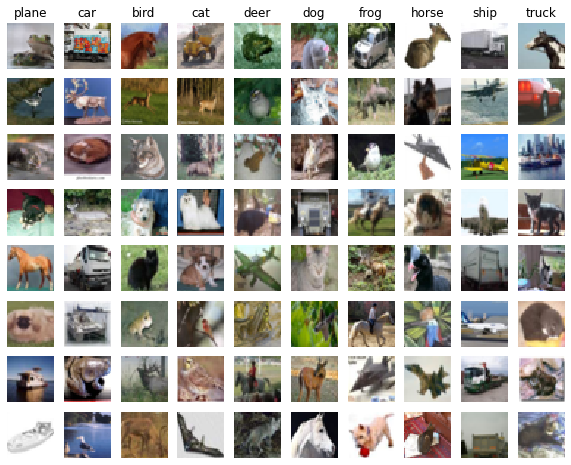

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$
*可以看到把马或者青蛙错分成飞机等，还是有一定道理的，因为分错的物体轮廓很相似或者是颜色相似*




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [10]:
from sducs2019.classifiers.neural_net import ThreeLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = ThreeLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
################################################################################
# TODO: Train a three-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#pass
best_val = -1
result = {}

for learning_rate in [5e-1, 1.0,2.0]:
    for reg in [1e-6, 1e-5, 5e-5]:
        net = ThreeLayerNet(input_dim, hidden_dim, num_classes)
        stats=net.train(X_train_feats, y_train, X_val_feats, y_val,num_iters=10000, batch_size=150,learning_rate=learning_rate, learning_rate_decay=0.95,reg=reg, verbose=True)
        train_acc = np.mean(y_train == net.predict(X_train_feats))
        val_acc = np.mean(y_val == net.predict(X_val_feats))
        result[(learning_rate, reg)] = train_acc, val_acc
        if  val_acc>best_val :
            best_val = val_acc
            best_net = net
        print('lr %e reg %e training acc: %f val acc: %f'%(lr,reg,train_acc,val_acc))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 0 / 10000: loss 2.302585
iteration 100 / 10000: loss 2.303126
iteration 200 / 10000: loss 2.304921
iteration 300 / 10000: loss 2.303642
iteration 400 / 10000: loss 2.299611
iteration 500 / 10000: loss 2.300671
iteration 600 / 10000: loss 2.302458
iteration 700 / 10000: loss 2.304272
iteration 800 / 10000: loss 2.303568
iteration 900 / 10000: loss 2.302736
iteration 1000 / 10000: loss 2.306174
iteration 1100 / 10000: loss 2.301373
iteration 1200 / 10000: loss 2.299025
iteration 1300 / 10000: loss 2.309119
iteration 1400 / 10000: loss 2.309111
iteration 1500 / 10000: loss 2.303337
iteration 1600 / 10000: loss 2.302050
iteration 1700 / 10000: loss 2.307654
iteration 1800 / 10000: loss 2.304487
iteration 1900 / 10000: loss 2.305814
iteration 2000 / 10000: loss 2.301572
iteration 2100 / 10000: loss 2.297018
iteration 2200 / 10000: loss 2.306936
iteration 2300 / 10000: loss 2.303649
iteration 2400 / 10000: loss 2.306543
iteration 2500 / 10000: loss 2.303316
iteration 2600 / 10000: 

iteration 1300 / 10000: loss 2.304926
iteration 1400 / 10000: loss 2.298302
iteration 1500 / 10000: loss 2.304686
iteration 1600 / 10000: loss 2.303043
iteration 1700 / 10000: loss 2.302912
iteration 1800 / 10000: loss 2.304880
iteration 1900 / 10000: loss 2.304833
iteration 2000 / 10000: loss 2.303491
iteration 2100 / 10000: loss 2.304844
iteration 2200 / 10000: loss 2.301703
iteration 2300 / 10000: loss 2.299199
iteration 2400 / 10000: loss 2.300220
iteration 2500 / 10000: loss 2.307220
iteration 2600 / 10000: loss 2.302158
iteration 2700 / 10000: loss 2.306400
iteration 2800 / 10000: loss 2.303833
iteration 2900 / 10000: loss 2.302069
iteration 3000 / 10000: loss 2.303881
iteration 3100 / 10000: loss 2.304296
iteration 3200 / 10000: loss 2.303963
iteration 3300 / 10000: loss 2.304729
iteration 3400 / 10000: loss 2.307313
iteration 3500 / 10000: loss 2.307160
iteration 3600 / 10000: loss 2.308306
iteration 3700 / 10000: loss 2.306280
iteration 3800 / 10000: loss 2.305079
iteration 39

iteration 2600 / 10000: loss 2.306037
iteration 2700 / 10000: loss 2.310681
iteration 2800 / 10000: loss 2.305657
iteration 2900 / 10000: loss 2.304907
iteration 3000 / 10000: loss 2.303820
iteration 3100 / 10000: loss 2.303989
iteration 3200 / 10000: loss 2.316093
iteration 3300 / 10000: loss 2.298703
iteration 3400 / 10000: loss 2.301905
iteration 3500 / 10000: loss 2.303595
iteration 3600 / 10000: loss 2.316599
iteration 3700 / 10000: loss 2.303870
iteration 3800 / 10000: loss 2.302570
iteration 3900 / 10000: loss 2.305556
iteration 4000 / 10000: loss 2.301935
iteration 4100 / 10000: loss 2.307066
iteration 4200 / 10000: loss 1.988573
iteration 4300 / 10000: loss 1.803966
iteration 4400 / 10000: loss 1.506005
iteration 4500 / 10000: loss 1.251721
iteration 4600 / 10000: loss 1.381850
iteration 4700 / 10000: loss 1.282057
iteration 4800 / 10000: loss 1.218789
iteration 4900 / 10000: loss 1.155909
iteration 5000 / 10000: loss 1.147536
iteration 5100 / 10000: loss 1.206497
iteration 52

iteration 3900 / 10000: loss 2.296293
iteration 4000 / 10000: loss 2.321315
iteration 4100 / 10000: loss 2.298678
iteration 4200 / 10000: loss 2.309331
iteration 4300 / 10000: loss 2.314522
iteration 4400 / 10000: loss 2.297558
iteration 4500 / 10000: loss 2.305900
iteration 4600 / 10000: loss 2.308943
iteration 4700 / 10000: loss 2.308244
iteration 4800 / 10000: loss 2.300514
iteration 4900 / 10000: loss 2.321780
iteration 5000 / 10000: loss 2.306466
iteration 5100 / 10000: loss 2.305760
iteration 5200 / 10000: loss 2.297090
iteration 5300 / 10000: loss 2.306151
iteration 5400 / 10000: loss 2.313531
iteration 5500 / 10000: loss 2.305405
iteration 5600 / 10000: loss 2.312167
iteration 5700 / 10000: loss 2.312066
iteration 5800 / 10000: loss 2.302387
iteration 5900 / 10000: loss 2.302062
iteration 6000 / 10000: loss 2.298567
iteration 6100 / 10000: loss 2.310228
iteration 6200 / 10000: loss 2.297772
iteration 6300 / 10000: loss 2.302035
iteration 6400 / 10000: loss 2.294330
iteration 65

iteration 5200 / 10000: loss 2.311888
iteration 5300 / 10000: loss 2.307093
iteration 5400 / 10000: loss 2.309545
iteration 5500 / 10000: loss 2.302242
iteration 5600 / 10000: loss 2.302247
iteration 5700 / 10000: loss 2.319327
iteration 5800 / 10000: loss 2.303673
iteration 5900 / 10000: loss 2.302524
iteration 6000 / 10000: loss 2.302428
iteration 6100 / 10000: loss 2.309562
iteration 6200 / 10000: loss 2.308953
iteration 6300 / 10000: loss 2.301580
iteration 6400 / 10000: loss 2.311182
iteration 6500 / 10000: loss 2.315260
iteration 6600 / 10000: loss 2.305406
iteration 6700 / 10000: loss 2.306281
iteration 6800 / 10000: loss 2.309303
iteration 6900 / 10000: loss 2.301528
iteration 7000 / 10000: loss 2.301335
iteration 7100 / 10000: loss 2.310315
iteration 7200 / 10000: loss 2.304746
iteration 7300 / 10000: loss 2.309997
iteration 7400 / 10000: loss 2.304627
iteration 7500 / 10000: loss 2.308350
iteration 7600 / 10000: loss 2.316163
iteration 7700 / 10000: loss 2.304860
iteration 78

In [11]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.577
